# Телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг
Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Цель проекта - предсказать ухода клиента.
### План проекта:
1. Загрузка и анализ данных
2. Предобработка данных
        - Объединение таблиц;
        - Исследование единого датафрейма (обработка пропусков и дубликатов);
        - Выделение целевого признака;
        - Проверка корреляции.
3. Обучение моделей
        - Подготовка данных (разделение подготовленных данных с размером тестовой выборки 0,25);
        - Кодирование категориальных признаков;
        - Масштабирование числовых признаков;
        - Борьба с дисбалансом;
        - Исследование качества разных моделей, подбор гиперпараметров;
        - Обучение разных моделей и оценка их качества;
        - Выбор лучшей модели и ее финальное тестирование;
        - Получение ROC-AUC >= 0,85 на тестовой выборке
4. Выводы        

### На данном этапе воросов к тимлиду нет. На вебинаре очень подробно все раскрыли.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## 1. Загрузка и анализ данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 91.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Импортируем библиотеки.
import warnings
import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from datetime import date
from sklearn.inspection import permutation_importance


from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import (
    CatBoostClassifier
)    

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 170723
CLASS_WEIGHT='balanced'

In [5]:
#Считываем данные из csv-файлов в датафрейм
try:
    data_contract = pd.read_csv('datasets/contract_new.csv')
except:
    data_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    
try:
    data_personal = pd.read_csv('datasets/personal_new.csv')
except:
    data_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')   
    
try:
    data_internet = pd.read_csv('datasets/internet_new.csv')
except:
    data_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    
try:
    data_phone = pd.read_csv('datasets/phone_new.csv')
except:
    data_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')      

Посмотрим каждую таблицу

In [6]:
#Функция получения первичной информации о датафрейме
def studying_the_data (data):
    print ('------------- Первые 5 строк ------------')
    display(data.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    data.info()
    print('')
    print('')
    print ('------------- Статистические данные ------------')
    display(data.describe())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in data.columns:
        if data[element].isna().sum() > 0: 
            print(element, ' - ', data[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print(element, 'Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

studying_the_data (data_contract)

------------- Первые 5 строк ------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


------------- Статистические данные ------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000




------------- Пропуски ------------
customerID Пропусков НЕТ
BeginDate Пропусков НЕТ
EndDate Пропусков НЕТ
Type Пропусков НЕТ
PaperlessBilling Пропусков НЕТ
PaymentMethod Пропусков НЕТ
MonthlyCharges Пропусков НЕТ
TotalCharges Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


In [7]:
studying_the_data (data_personal)

------------- Первые 5 строк ------------


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


------------- Статистические данные ------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000




------------- Пропуски ------------
customerID Пропусков НЕТ
gender Пропусков НЕТ
SeniorCitizen Пропусков НЕТ
Partner Пропусков НЕТ
Dependents Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


In [8]:
studying_the_data (data_internet)

------------- Первые 5 строк ------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


------------- Статистические данные ------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7853-OETYL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785




------------- Пропуски ------------
customerID Пропусков НЕТ
InternetService Пропусков НЕТ
OnlineSecurity Пропусков НЕТ
OnlineBackup Пропусков НЕТ
DeviceProtection Пропусков НЕТ
TechSupport Пропусков НЕТ
StreamingTV Пропусков НЕТ
StreamingMovies Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


In [9]:
studying_the_data (data_phone)

------------- Первые 5 строк ------------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


------------- Статистические данные ------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4854-CIDCF,No
freq,1,3390




------------- Пропуски ------------
customerID Пропусков НЕТ
MultipleLines Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


### Вывод
Данные загружены. Пропуски и явные дуликаты при первичном анализе не выявлены. 

## 2. Предобработка данных

Проверим уникальность записей customerID в таблице data_personal

In [10]:
data_personal['customerID'].nunique()

7043

Записи уникальны, так как совпадают с количеством записей в таблице. Назначим поле в качестве индекса. 

In [11]:
data_personal = data_personal.set_index('customerID')

Проверим уникальность записей customerID в таблице data_contract

In [12]:
data_contract['customerID'].nunique()

7043

Записи уникальны, так как совпадают с количеством записей в таблице. Назначим поле в качестве индекса.

In [13]:
data_contract = data_contract.set_index('customerID')

Проверим уникальность записей customerID в таблице data_internet

In [14]:
data_internet['customerID'].nunique()

5517

Записи уникальны, так как совпадают с количеством записей в таблице. Назначим поле в качестве индекса.

In [15]:
data_internet = data_internet.set_index('customerID')

Проверим уникальность записей customerID в таблице data_phone

In [16]:
data_phone['customerID'].nunique()

6361

Записи уникальны, так как совпадают с количеством записей в таблице. Назначим поле в качестве индекса.

In [17]:
data_phone = data_phone.set_index('customerID')

Объединять будем по полю customerID

In [18]:
data = data_personal.join([data_contract, data_internet, data_phone])

In [19]:
studying_the_data (data)

------------- Первые 5 строк ------------


,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   obje

,SeniorCitizen,MonthlyCharges
count,7043.000000,7043.000000
mean,0.162147,64.761692
std,0.368612,30.090047
min,0.000000,18.250000
25%,0.000000,35.500000
50%,0.000000,70.350000
75%,0.000000,89.850000
max,1.000000,118.750000




------------- Пропуски ------------
gender Пропусков НЕТ
SeniorCitizen Пропусков НЕТ
Partner Пропусков НЕТ
Dependents Пропусков НЕТ
BeginDate Пропусков НЕТ
EndDate Пропусков НЕТ
Type Пропусков НЕТ
PaperlessBilling Пропусков НЕТ
PaymentMethod Пропусков НЕТ
MonthlyCharges Пропусков НЕТ
TotalCharges Пропусков НЕТ
InternetService  -  1526 пропусков
OnlineSecurity  -  1526 пропусков
OnlineBackup  -  1526 пропусков
DeviceProtection  -  1526 пропусков
TechSupport  -  1526 пропусков
StreamingTV  -  1526 пропусков
StreamingMovies  -  1526 пропусков
MultipleLines  -  682 пропусков


------------- Дубликаты ------------
Дубликатов:  4


Для начала удалим дубликаты, их всего 4.

In [20]:
data.drop_duplicates(inplace=True)

In [21]:
data.duplicated().sum()

0

In [22]:
data.isna().sum()

gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1523
OnlineSecurity      1523
OnlineBackup        1523
DeviceProtection    1523
TechSupport         1523
StreamingTV         1523
StreamingMovies     1523
MultipleLines        682
dtype: int64

Заменим пропуски в столбцах с дополнительными услугами OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. Будем считать если поле не заполнено, то услуга не подключена. Следовательно пропуски заменять будем на "No".

In [23]:
fillna_no = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
             'StreamingTV','StreamingMovies','MultipleLines']
for i in fillna_no:
    data[i].fillna('No', inplace=True)

In [24]:
data.isna().sum()

gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1523
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64

Заменим пропуски в столбце InternetService на 'None'.

In [25]:
data['InternetService'].fillna('None', inplace=True)

In [26]:
data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [27]:
data.head(15)

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,Female,0,No,No,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,No
7892-POOKP,Female,0,Yes,No,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


Преобразуем формат столбца TotalCharges в числовой.

In [28]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

Теперь проверим пропуски в столбце TotalCharges.

In [29]:
data['TotalCharges'].isna().sum()

11

Посмотрим на строки с пропусками

In [30]:
data[data['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,No
3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,None,No,No,No,No,No,No,No
5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,None,No,No,No,No,No,No,Yes
1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,No
7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,None,No,No,No,No,No,No,No
3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,None,No,No,No,No,No,No,Yes
2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,None,No,No,No,No,No,No,No
2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,None,No,No,No,No,No,No,No


У все пропусков BeginDate 2020-02-01 и проставлен столбец MonthlyCharges. Теоретически можно расчитать TotalCharges=MonthlyCharges * на длительность контаракта. Но пропусков всего 11, поэтому мы их удалим.

In [31]:
data = data.dropna(subset=['TotalCharges'])

Проверим пропуски

In [32]:
data['TotalCharges'].isna().sum()

0

Преобразуем формат столбцов BeginDate в datetime.

In [33]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')

Добавим столбец с целевым признаком, ушел/не ушел. Определять будем по столбцу EndDate, если стоит дата, значит ушел.

In [34]:
data['target'] = pd.Series(np.where(data['EndDate'].values == 'No', 0, 1), data.index)

In [35]:
data['target'].head(10)

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    0
7795-CFOCW    0
9237-HQITU    0
9305-CDSKC    0
1452-KIOVK    0
6713-OKOMC    0
7892-POOKP    0
6388-TABGU    1
Name: target, dtype: int64

Создадим новый признак длительности контракта.

Сделаем сортировку по BeginDate и посмотрим.

In [36]:
data.head().sort_values(by='BeginDate', ascending=False)

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,0
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,0
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,0


Крайняя дата 2020-01-01, так как ранее были удалены строки с пропусками в TotalCharges, с датой 2020-02-01. Можно предположить, что это дата выгрузки файлов.

Заменим значение 'No' в столбце EndDate на дату выгрузки 2020-02-01

In [37]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

Преобразуем формат столбца EndDate в datetime.

In [38]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [39]:
data['EndDate'].head(10)

customerID
7590-VHVEG   2020-02-01
5575-GNVDE   2020-02-01
3668-QPYBK   2020-02-01
7795-CFOCW   2020-02-01
9237-HQITU   2020-02-01
9305-CDSKC   2020-02-01
1452-KIOVK   2020-02-01
6713-OKOMC   2020-02-01
7892-POOKP   2020-02-01
6388-TABGU   2017-05-01
Name: EndDate, dtype: datetime64[ns]

Создадим признак duration

In [40]:
data['duration'] = data['EndDate'] - data['BeginDate']

In [41]:
data['duration'].head(20)

customerID
7590-VHVEG     31 days
5575-GNVDE   1036 days
3668-QPYBK    123 days
7795-CFOCW   1371 days
9237-HQITU    153 days
9305-CDSKC    337 days
1452-KIOVK    671 days
6713-OKOMC    306 days
7892-POOKP    945 days
6388-TABGU    882 days
9763-GRSKD    396 days
7469-LKBCI    488 days
8091-TTVAX   1767 days
0280-XJGEX   1614 days
5129-JLPIS    761 days
3655-SNQYZ    670 days
8191-XWSZG   1584 days
9959-WOFKT   2163 days
4190-MFLUW    396 days
4183-MYFRB    641 days
Name: duration, dtype: timedelta64[ns]

Преобразуем формат нового признака в числовой.

In [42]:
data['duration'] = data['duration'].dt.days.astype('int')

Удалим столбцы BeginDate и EndDate, чтобы избежать утечки данных.

In [43]:
data.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

In [44]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,0,153


### Матрица корреляции

Построим матрицу корреляции phik.

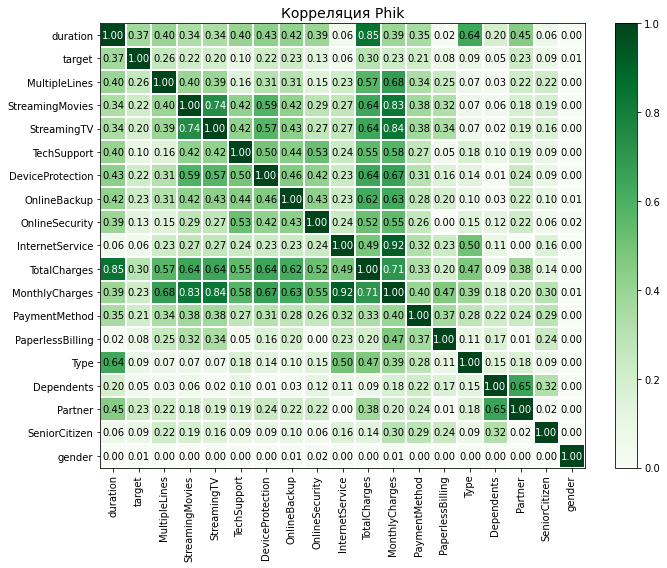

In [45]:
#В параметре передадим числовые признаки
interval_cols = ['MonthlyCharges', 'TotalCharges', 'duration']
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title="Корреляция Phik", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

Мы видим, что существует большая корреляция между такими признаками, как InternetService и MonthlyCharges. Удалим один из признаков.

In [46]:
data.drop(['MonthlyCharges'], axis=1, inplace=True)

### Дисбаланс классов

Проверим на дисбаланс классов целевой признак.

In [47]:
disbalance = data['target'].value_counts(normalize = bool)
print (disbalance)

0    0.843341
1    0.156659
Name: target, dtype: float64


<AxesSubplot:title={'center':'График дисбаланса'}>

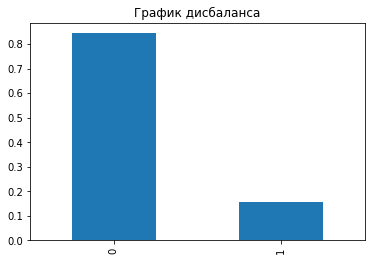

In [48]:
disbalance.plot(kind='bar', title='График дисбаланса')

Наблюдается явный дисбаланс классов целевого признака.

### Исследовательский анализ

In [49]:
all_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'MultipleLines']
num_cols = ['duration', 'TotalCharges']
cat_col_bin = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines']
cat_col_mul = ['Type', 'PaymentMethod', 'InternetService']

Построим диаграммы распределения клиентов по признакам.

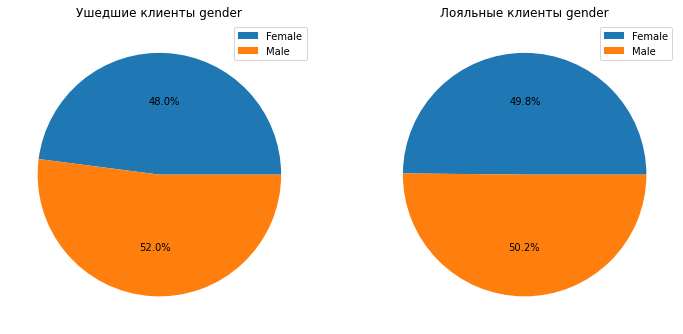

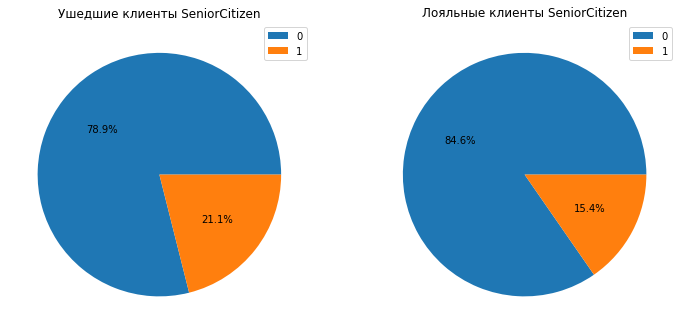

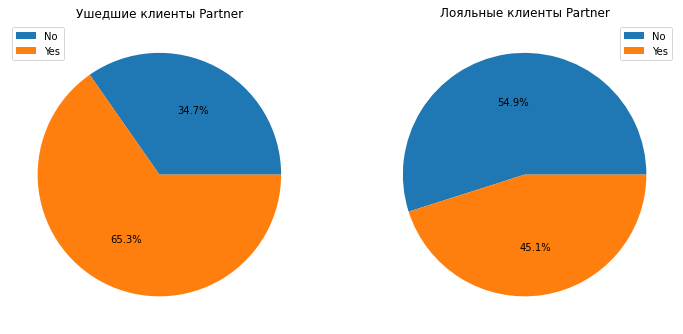

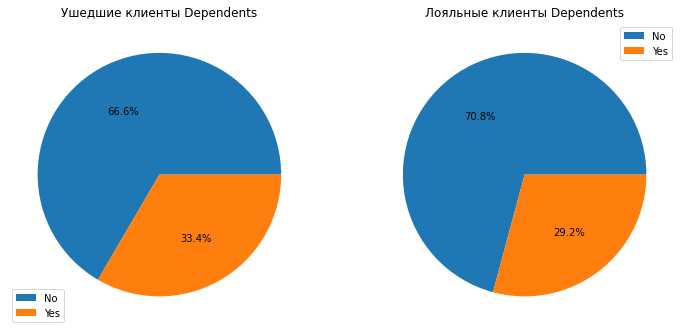

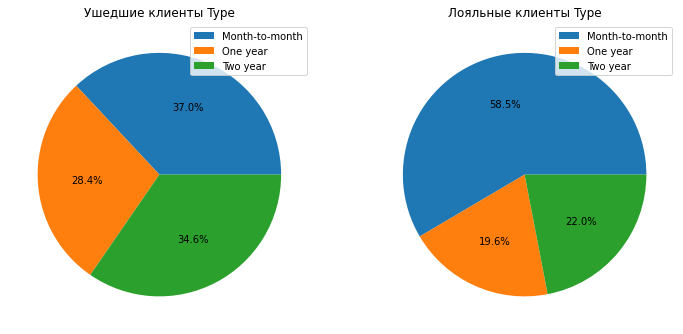

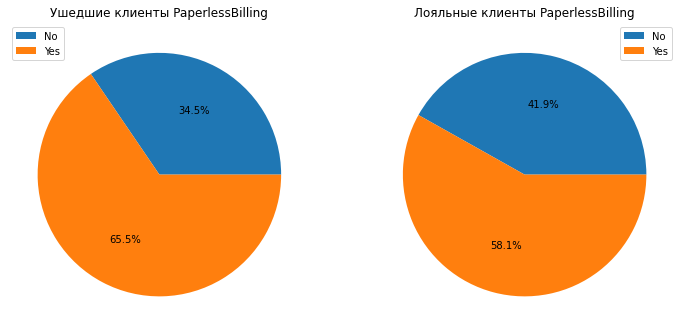

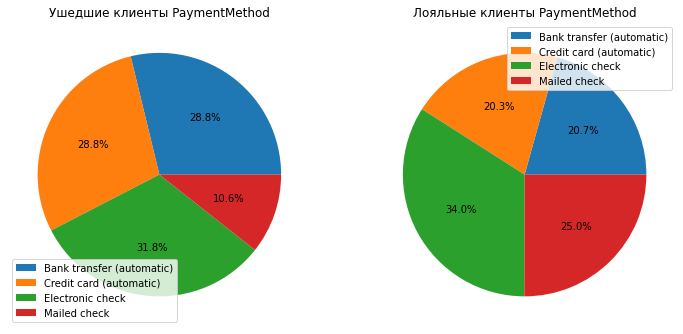

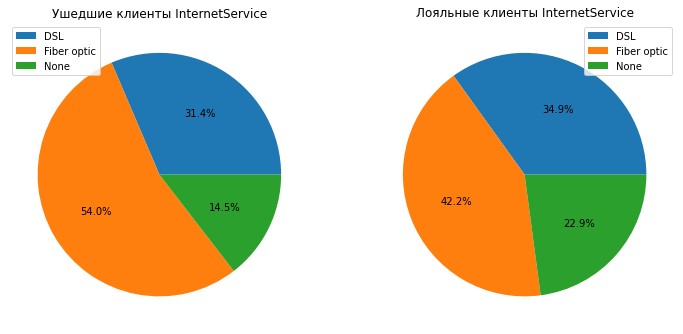

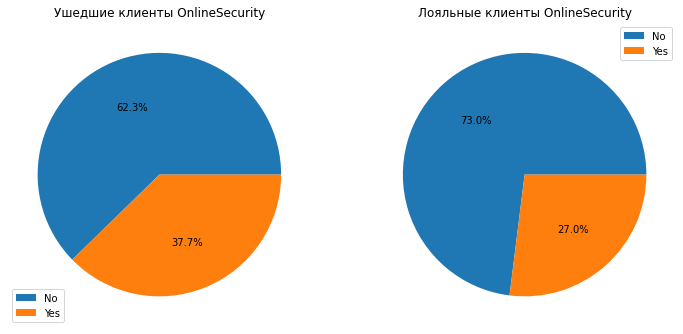

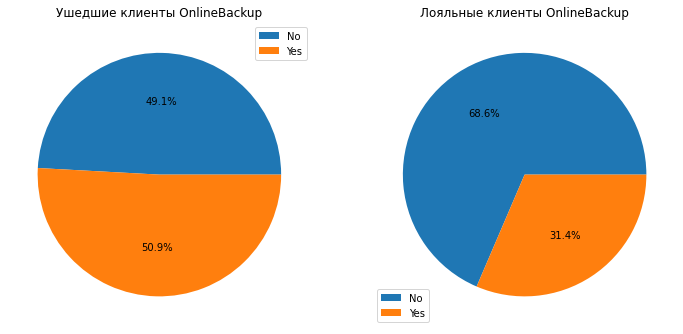

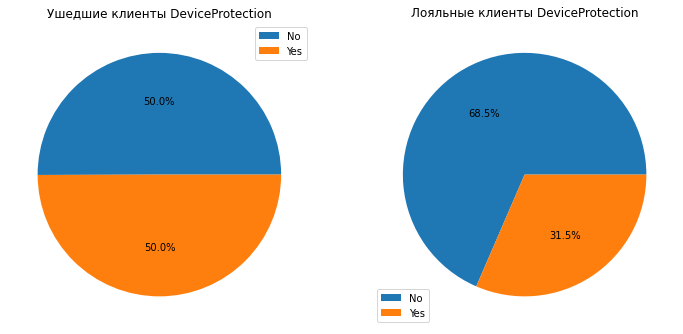

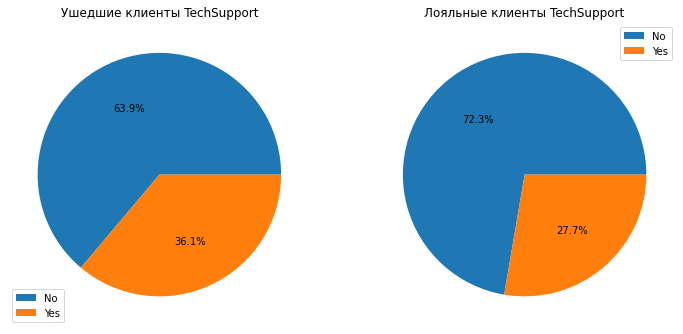

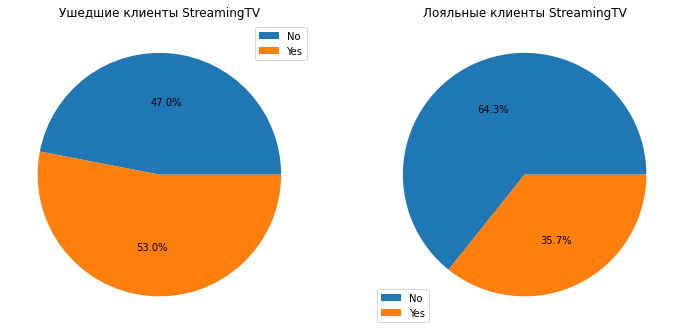

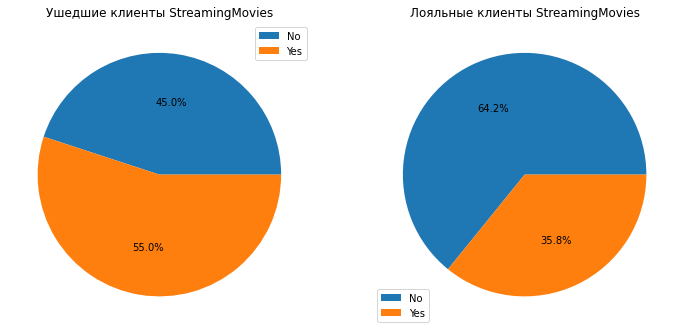

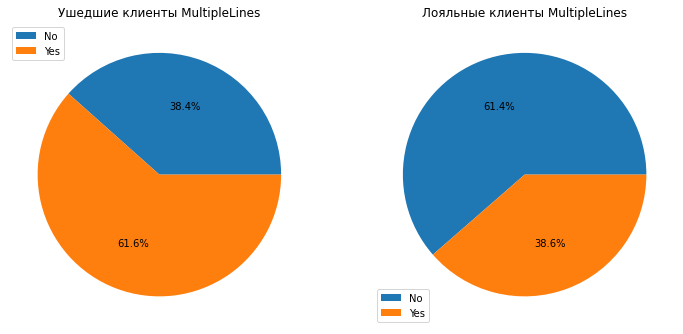

In [50]:
for i in all_cols:
    data_1 = data.query('target == 1').groupby(i)[['target']].count()
    data_0 = data.query('target == 0').groupby(i)[['target']].count()

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(data_1.loc[:, 'target'], autopct='%1.1f%%')
    plt.legend(labels=data_1.index, loc='best')
    plt.title('Ушедшие клиенты '+i)
    plt.ylabel("")


    plt.subplot(1, 2, 2)
    plt.pie(data_0.loc[:, 'target'], autopct='%1.1f%%')
    plt.legend(labels=data_1.index, loc='best')
    plt.title('Лояльные клиенты '+i)
    plt.show()

По диаграммам можно сделать вывод, что на уход клиента незначительно влияют признаки: Partner, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines.

## 3. Обучение тестирование моделей

Сделаем замену в бинарных признаках на 0/1.

In [51]:
for i in cat_col_bin:
    data[i] = (data[[i]].replace({'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1}))

In [52]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,Month-to-month,1,Electronic check,31.04,DSL,0,1,0,0,0,0,0,0,31
5575-GNVDE,1,0,0,0,One year,0,Mailed check,2071.84,DSL,1,0,1,0,0,0,0,0,1036
3668-QPYBK,1,0,0,0,Month-to-month,1,Mailed check,226.17,DSL,1,1,0,0,0,0,0,0,123
7795-CFOCW,1,0,0,0,One year,0,Bank transfer (automatic),1960.60,DSL,1,0,1,1,0,0,0,0,1371
9237-HQITU,0,0,0,0,Month-to-month,1,Electronic check,353.50,Fiber optic,0,0,0,0,0,0,0,0,153


Выделим целевой признак и разделим датасет на тренировочную и тестовую выборки. 

In [53]:
features = data.drop(['target'], axis=1)
target = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

In [54]:
print(X_train.shape[0])
print(y_train.shape[0])
print(X_test.shape[0])
print(y_test.shape[0])

5271
5271
1757
1757


In [55]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
customerID,,,,,,,,,,,,,,,,,
4607-CHPCA,1,0,1,1,One year,1,Electronic check,2778.90,Fiber optic,0,0,0,0,1,1,0,883
6688-UZPWD,0,0,1,0,Month-to-month,1,Electronic check,1530.00,Fiber optic,0,1,0,0,1,1,1,457
1116-FRYVH,0,0,1,1,Two year,0,Mailed check,1910.11,DSL,1,1,0,1,0,0,0,1461
6872-HXFNF,0,0,1,0,One year,0,Bank transfer (automatic),4070.50,DSL,0,0,1,1,0,0,1,1949
0303-UNCIP,1,0,0,0,One year,0,Mailed check,2665.00,DSL,0,0,1,0,0,1,1,1248


### Кодирование и масштабирование

Применим кодирование и масштабирование используя make_column_transformer.

In [56]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [57]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_col_mul
    ),
    (
        StandardScaler(), 
        num_cols
    ),
    remainder='passthrough'
)

### Подбор гиперпараметров и обучение моделей

Проверим модел: LogisticRegression, RandomForestClassifier, CatBoostClassifier

Модель LogisticRegression

In [58]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE)

pipline_lr = make_pipeline(col_transformer, model_lr)

param_grid_lr ={
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # метод оптимизации
    'logisticregression__C': [0.0001, 0.01, 0.1, 1] #  константа, обратная к константе перед регуляризацией
} 

gs_lr = GridSearchCV(
    pipline_lr, 
    param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_lr.fit(X_train_lr, y_train)

gs_lr_best_score = gs_lr.best_score_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_lr_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_lr.best_params_}')

best_score: 0.7670050279859596
best_params: {'logisticregression__C': 1, 'logisticregression__solver': 'newton-cg'}
CPU times: user 15.5 s, sys: 16.7 s, total: 32.3 s
Wall time: 32.6 s


Модель RandomForestClassifier

In [59]:
X_train_rfc = X_train.copy()
X_test_rfc = X_test.copy()

In [60]:
%%time

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rfc = make_pipeline(col_transformer, model_rfc)

param_grid_rfc = {
    'randomforestclassifier__max_depth': range(10, 30, 1), # глубина
    'randomforestclassifier__n_estimators': range(50, 151, 10) # количество деревьев
} 
    
gs_rfc = GridSearchCV(
    pipline_rfc, 
    param_grid_rfc, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_rfc.fit(X_train_rfc, y_train)

gs_rfc_best_score = gs_rfc.best_score_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_rfc_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_rfc.best_params_}')

best_score: 0.8262409737118019
best_params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 150}
CPU times: user 7min 27s, sys: 2.4 s, total: 7min 30s
Wall time: 7min 38s


Модель CatBoostClassifier

In [61]:
X_train_cbc = X_train.copy()
X_test_cbc = X_test.copy()

In [62]:
%%time

model_cbc = CatBoostClassifier(random_state=RANDOM_STATE)

pipline_cbc = make_pipeline(col_transformer, model_cbc)

param_grid_cbc = {
    'catboostclassifier__learning_rate': [0.03, 0.1], # скорость обучения
    'catboostclassifier__depth': [4, 6, 10], # глубина
    'catboostclassifier__l2_leaf_reg': [1, 3, 5,], # регуляризацию L2-листа
    'catboostclassifier__iterations': [50, 100, 150] # количество итераций
} 
    
gs_cbc = GridSearchCV(
    pipline_cbc, 
    param_grid_cbc, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_cbc.fit(X_train_cbc, y_train)

gs_cbc_best_score = gs_cbc.best_score_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_cbc_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_cbc.best_params_}')

0:	learn: 0.6713347	total: 47.7ms	remaining: 2.34s
1:	learn: 0.6480820	total: 49ms	remaining: 1.18s
2:	learn: 0.6296198	total: 50ms	remaining: 784ms
3:	learn: 0.6144953	total: 51ms	remaining: 586ms
4:	learn: 0.5965397	total: 52ms	remaining: 468ms
5:	learn: 0.5800715	total: 53ms	remaining: 389ms
6:	learn: 0.5651628	total: 54ms	remaining: 332ms
7:	learn: 0.5534435	total: 55ms	remaining: 289ms
8:	learn: 0.5392016	total: 56ms	remaining: 255ms
9:	learn: 0.5269118	total: 57ms	remaining: 228ms
10:	learn: 0.5173998	total: 58ms	remaining: 206ms
11:	learn: 0.5080801	total: 59.1ms	remaining: 187ms
12:	learn: 0.4981332	total: 60.1ms	remaining: 171ms
13:	learn: 0.4884559	total: 61.1ms	remaining: 157ms
14:	learn: 0.4790929	total: 62.3ms	remaining: 145ms
15:	learn: 0.4706749	total: 63.3ms	remaining: 135ms
16:	learn: 0.4631102	total: 64.4ms	remaining: 125ms
17:	learn: 0.4552975	total: 65.4ms	remaining: 116ms
18:	learn: 0.4491004	total: 66.5ms	remaining: 108ms
19:	learn: 0.4416447	total: 67.4ms	remaini

In [63]:
result = pd.DataFrame(
    [gs_lr_best_score, gs_rfc_best_score, gs_cbc_best_score], 
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'], 
    columns=['ROC_AUC']
)
result

,ROC_AUC
LogisticRegression,0.767005
RandomForestClassifier,0.826241
CatBoostClassifier,0.887584


Лучшая модель с результатом ROC_AUC=0.887584 - CatBoostClassifier

### Тестирование лучшей модели

In [64]:
cbc_prediction_proba = gs_cbc.predict_proba(X_test_cbc)[:,1]
metric_roc_auc = roc_auc_score(y_test, cbc_prediction_proba)
print(f'roc_auc: {metric_roc_auc}')

roc_auc: 0.9004453441295547


In [65]:
cbc_prediction = gs_cbc.predict(X_test_cbc)
metric_accuracy = accuracy_score(y_test, cbc_prediction)
print(f'accuracy_score: {metric_accuracy}')

accuracy_score: 0.8992601024473534


Лучшая модель CatBoostClassifier на тестовой выборке показала ROC_AUC: 0.9004453441295547, accuracy: 0.8992601024473534

### ROC-кривая

[[<matplotlib.axis.XTick at 0x7f4040a861f0>,

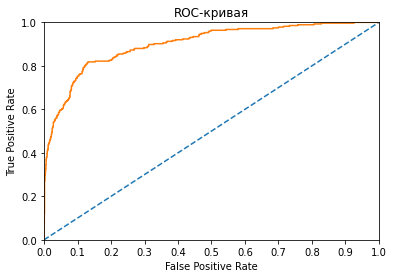

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, cbc_prediction_proba)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.gca().xaxis.set(ticks=np.arange(0,1.1,0.1))

График ROC-кривой показывает довольно не плохой результат.

### Матрица ошибок

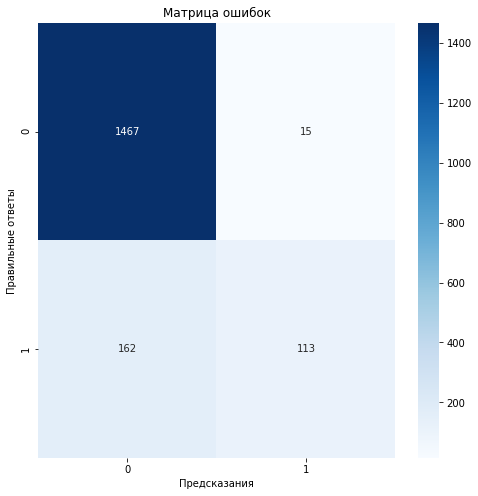

In [67]:
cbc_matrix = confusion_matrix(y_test, cbc_prediction)
plt.figure(figsize=(8, 8))
sns.heatmap(cbc_matrix, 
            annot=True,  
            cmap='Blues', 
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

Матрица ошибок показывает отличные резултаты

Визуализируем важность признаков

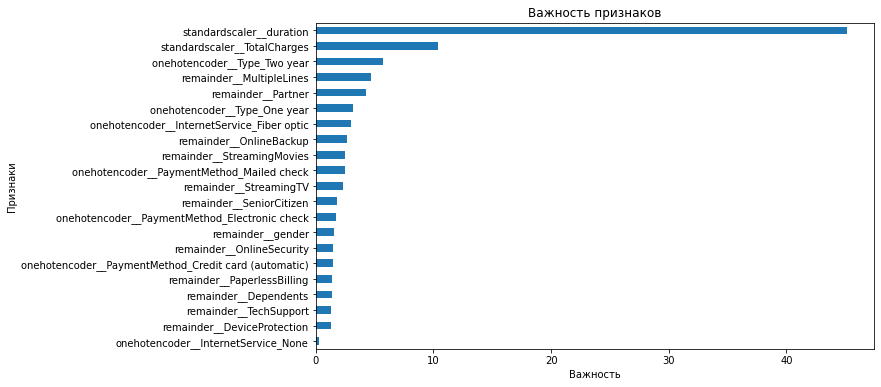

In [68]:
feature_importance = gs_cbc.best_estimator_.named_steps['catboostclassifier'].get_feature_importance()
col_transformer.fit(X_train)
feature_names = col_transformer.get_feature_names_out()

feature_importance = pd.Series(feature_importance, index=feature_names)

plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

## 4. Выводы

1. Представленные данные в четырех файлах были объединены в один датасет.
2. Проведена предобработка:
    - Удалили дубликаты.
    - Удалили пропуски в столбце TotalCharges.
    - Заменили пропуски в столбцах с дополнительными услугами OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies на "No". Заменили пропуски в столбце InternetService на 'None'.
    - Удалили столбцы BeginDate и EndDate, чтобы избежать утечки данных.
    - Создали целевой признак target ушел/не ушел.
    - Создали новый признак длительности контракта duration.
    - Построили матрицу корреляции phik. Выявили большую корреляция между такими признаками, как InternetService и MonthlyCharges. Удалили признак MonthlyCharges.
3. Проверили на дисбаланс классов целевой признак. Выявили явный дисбаланс классов, но балансировку не проводили, так как наша метрика не чувствительна к дисбалансу.
4. Провели исследовательский анализ данных. Построиди диаграммы распределения клиентов по признакам. По диаграммам сделали вывод, что на уход клиента незначительно влияют признаки: Partner, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines.
5. Провели обучение и тестирование моделей
    - Сделали замену в бинарных признаках на 0/1.
    - Выделили целевой признак и разделили датасет на тренировочную и тестовую выборки.
    - Применили кодирование и масштабирование используя make_column_transformer.
    - Обучили и проверили модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier
    - Получили ROC_AUC LogisticRegression - 0.768354, RandomForestClassifier - 0.817873, CatBoostClassifier - 0.863970
    - Выбрали лучшую модель CatBoostClassifier с результатом ROC_AUC=0.863970 и проверили ее на тестовой выборке.
    - Лучшая модель CatBoostClassifier на тестовой выборке показала ROC_AUC: 0.8672776346460558, accuracy: 0.8867387592487194
6. Построили График ROC-кривой, который показал довольно не плохой результат.
7. Построили матрицу ошибок с отличными резултатами.
8. Построили график важности признаков